In [1]:
# SETUP INSTRUCTIONS
# Run each cell below to set up environment
# Make sure to adjust subjectid and path variables
# Run pupillabs test BEFORE this protocol to ensure measurements are as expected
path_base = 'C:/Users/kebl6975/Documents/GitHub/cvd_pupillometry/subjectdata/'
# can add subject number + date
subject_id = 8
subj_base = 'sub-008/pipr-90s-binoc-sub-008_ses-01_dat-20230925' # pipr-sub-subjectID-ses-sesID-dat-date - sub-xxx-ses-xx-dat-yyyymmdd

In [2]:
# Set up stlab
from pyplr import stlab
d = stlab.SpectraTuneLab(password='2294b16eea08a15a')
d.turn_off()

LIGHT HUB login success
User authenticated as: admin
The following addresses are defined: [1, 1004, 1023]
Call get_luminaires() / get_device_info() for more info


<Response [200]>

Light engine is now set up, and so it is now possible to access the methods from the REST API. 

C:\Users\kebl6975\Documents\GitHub\cvd_pupillometry\pyplr\calibrate.py:368: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for led, df in self.data.groupby(["led"]):
C:\Users\kebl6975\Documents\GitHub\cvd_pupillometry\pyplr\calibrate.py:369: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  lkp_tbl = lkp_tbl.append(self.interp_led_spectra(led, df))
C:\Users\kebl6975\Documents\GitHub\cvd_pupillometry\pyplr\calibrate.py:369: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  lkp_tbl = lkp_tbl.append(self.interp_led_spectra(led, df))
C:\Users\kebl6975\Documents\GitHub\cvd_pupillometry\pyplr\calibrate.py:369: FutureWarning: The frame.append method is de

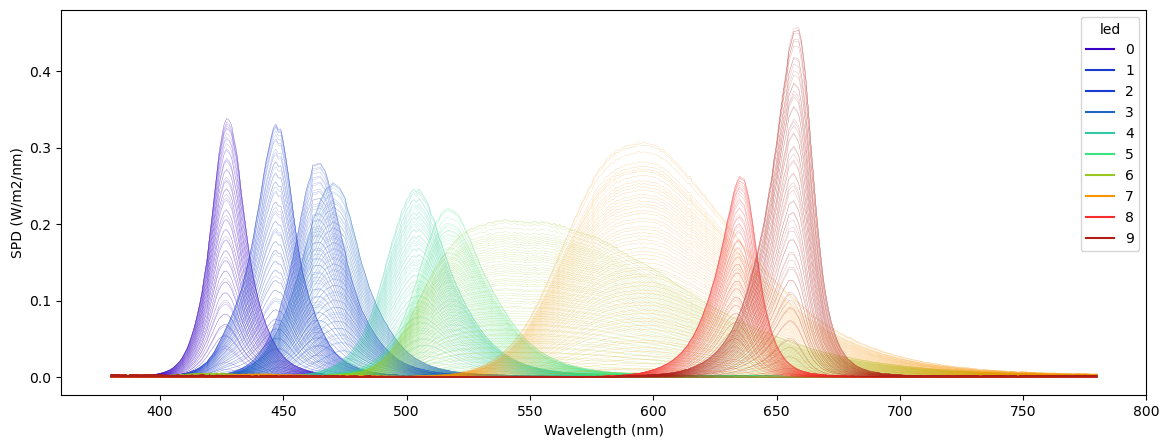

In [3]:
# from pyplr.calibrate import CalibrationContext as calibrationContext
# Calibration - important
import pyplr.calibrate as calb
from importlib import reload
reload(calb)
# file type to be read must be in format of:
# led | intensity | wavelength 1 (380) | wavelength 2 | ... | wavelength n (780)

cc = calb.CalibrationContext(
    'S2_corrected_oo_spectra.csv', binwidth=1)
_ = cc.plot_calibrated_spectra()


In [4]:
# calculate the peak spectral sensitivity for each LED at its maximum intensity setting
cc.lkp.xs(key=4095, level=1).idxmax(axis=1)

led
0    427
1    447
2    465
3    470
4    505
5    517
6    540
7    594
8    635
9    659
dtype: int64

In [5]:
blue_led = 3
red_led = 9
target_lux = 800

# Find the required intensity setting of the blue led for 800 lux
blue_intensity = (cc.lux.loc[blue_led].sub(target_lux)
                                      .abs()
                                      .idxmin())
#                                     .values[0])

# Find the intensity setting of the red led for 800 lux
red_intensity = cc.match(match_led=blue_led,
                         match_led_intensity=blue_intensity,
                         target_led=red_led,
                         match_type='irrad')[1]

C:\Users\kebl6975\Documents\GitHub\cvd_pupillometry\pyplr\CIE.py:5908: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  sss.index = pd.Int64Index(sss.index)


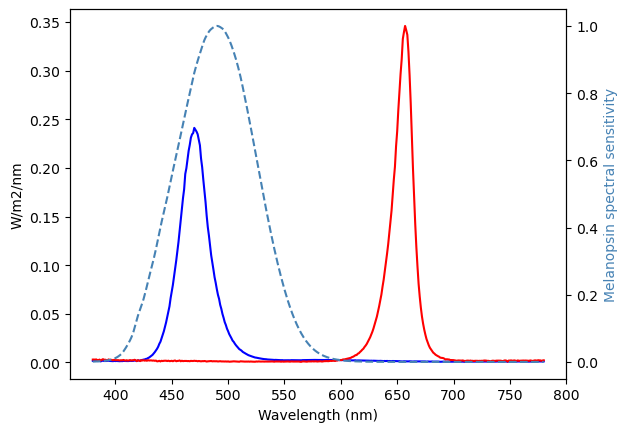

In [6]:
import matplotlib.pyplot as plt
from pyplr.CIE import get_CIES026

fig, ax = plt.subplots()
sss = get_CIES026(binwidth=1)
ax.plot(cc.lkp.loc[(blue_led, blue_intensity)], c='blue')
ax.plot(cc.lkp.loc[(red_led, red_intensity)], c='red')

ax2 = ax.twinx()
ax2.plot(sss['I'], ls='dashed', c='steelblue') # melanopsin = "I"
ax2.set_ylabel('Melanopsin spectral sensitivity', c='steelblue')
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('W/m2/nm');

In [7]:
from pyplr import stlab

blue_spec, red_spec = [0]*10, [0]*10
blue_spec[blue_led] = blue_intensity
red_spec[red_led] = red_intensity
d.turn_off()

<Response [200]>

In [8]:
from time import sleep
# import random # not using this library unless we want to randomize stims
from pyplr.pupil import PupilCore
from pyplr.utils import unpack_data_pandas
from pyplr.protocol import input_subject_id, subject_dir
# Connect to Pupil Core
p = PupilCore()
p.check_3d_model()

> Refit the 3d model? [y/n]: y
> Unfreezing 3d model for eye 0
> Unfreezing 3d model for eye 1
> Ask the participant to roll their eyes
> Press "Enter" when ready to freeze the model: 
> Freezing 3d model for eye 0
> Freezing 3d model for eye 1


Please enter subject ID: 008
> Grabbing 570 seconds of pupil.1.3d
> Grabbing 570 seconds of pupil.0.3d
> Waiting for a light to stamp...
> Light stamped on frame.world at 503423.47637499997
> Waiting for a light to stamp...
> Light stamped on frame.world at 503514.72842299996
> Waiting for a light to stamp...
> Light stamped on frame.world at 503606.008593
> Waiting for a light to stamp...
> Light stamped on frame.world at 503697.224664
> Waiting for a light to stamp...
> Light stamped on frame.world at 503788.508263
> Waiting for a light to stamp...
> Light stamped on frame.world at 503879.805674
Waiting for futures...
Waiting for futures...
Waiting for futures...
Waiting for futures...
Waiting for futures...
Waiting for futures...
Waiting for futures...
Waiting for futures...
Waiting for futures...
Waiting for futures...
Waiting for futures...
Waiting for futures...
Waiting for futures...
Waiting for futures...
Waiting for futures...
Waiting for futures...
Waiting for futures...
Wait

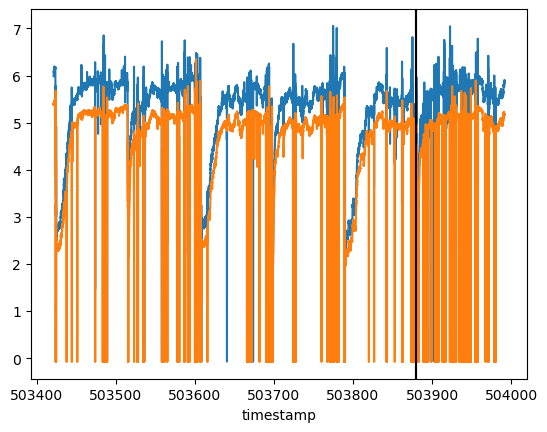

In [9]:
# PIPR STIMS - USE THIS ONE
d.turn_off()
subject_id = input_subject_id()
subj_dir = subject_dir(subject_id)
sleep(2)
ISI = 85 # interstimulus time (seconds) = this variable + 5s due to sleep + processing
num_trials = 6 # total number of trials
run_time = ISI*num_trials + 5*num_trials + 30 # appropriate offset to account for stim duration + sleeps


# Start a new recording called "my_recording"
p.command('R my_recording')

# Wait a few seconds
sleep(2)

# Make an annotation for when the light comes on
annotation = p.new_annotation('LIGHT_ON')

# Start the .light_stamper(...) and .pupil_grabber(...)
# this only captures one eye
# pgr_future = p.pupil_grabber(topic='pupil.1.3d', seconds=25) # time here is TOTAL run time
pgr_future_eye1 = p.pupil_grabber(topic='pupil.1.3d', seconds=run_time) # time here is TOTAL run time
pgr_future_eye0 = p.pupil_grabber(topic='pupil.0.3d', seconds=run_time) # time here is TOTAL run time

sleep(2)
##################################
# Administer light stimulus here #
led_list = [3,9]*3
# random.shuffle(led_list) # use this if stims should be randomized
for led in led_list:
    intensities = [0]*10
    if led == 3:
        intensities[led] = int(blue_intensity)
    else:
        intensities[led] = int(red_intensity)
    lst_future = p.light_stamper(annotation=annotation, timeout=10)
    d.set_spectrum_a(intensities)
    sleep(1.)
    d.turn_off()
    sleep(ISI)
    sleep(5) # make sure there is extra time so that trials do not overlap
##################################

# Wait for the futures
while lst_future.running() or pgr_future_eye0.running() or pgr_future_eye1.running():
    print('Waiting for futures...')
    sleep(1)

# End recording
p.command('r')

# Get the timestamp and pupil data
timestamp = lst_future.result()[1]
data_eye0 = unpack_data_pandas(pgr_future_eye0.result())
data_eye1 = unpack_data_pandas(pgr_future_eye1.result())
# timestamps are displayed in the output as well
# Plot the PLR
ax_0 = data_eye0['diameter_3d'].plot()
ax_0.axvline(x=timestamp, color='k')
ax_1 = data_eye1['diameter_3d'].plot()
ax_1.axvline(x=timestamp, color='k')

In [10]:
# display data from pandas table
data_eye0

,id,topic,method,norm_pos,diameter,confidence,sphere,projected_sphere,circle_3d,diameter_3d,ellipse,location,model_confidence,theta,phi
timestamp,,,,,,,,,,,,,,,
503421.459331,0,pupil.0.3d,pye3d 0.3.0 real-time,"[0.3169250298619508, 0.18661560573494151]",57.164295,1.0,"{'center': [2.8852223697196093, 5.695428753298...","{'center': [115.3151467788002, 134.30681345754...","{'center': [-3.750048564317493, 7.011705014003...",5.987581,"{'center': [60.849605733494556, 156.1698036988...","[60.849605733494556, 156.16980369889123]",1.0,1.443796,-2.270071
503421.467448,0,pupil.0.3d,pye3d 0.3.0 real-time,"[0.316902176556913, 0.18645870690134736]",57.207541,1.0,"{'center': [2.8852223697196093, 5.695428753298...","{'center': [115.3151467788002, 134.30681345754...","{'center': [-3.7507318669027203, 7.01521930167...",5.992427,"{'center': [60.845217898927295, 156.1999282749...","[60.845217898927295, 156.1999282749413]",1.0,1.443456,-2.270195
503421.475349,0,pupil.0.3d,pye3d 0.3.0 real-time,"[0.31693774424475435, 0.18647393394975398]",57.262193,1.0,"{'center': [2.8852223697196093, 5.695428753298...","{'center': [115.3151467788002, 134.30681345754...","{'center': [-3.7501606101888063, 7.01476430588...",5.998440,"{'center': [60.85204689499283, 156.19700468164...","[60.85204689499283, 156.19700468164723]",1.0,1.443500,-2.270118
503421.483531,0,pupil.0.3d,pye3d 0.3.0 real-time,"[0.3168003907923507, 0.18623924052710994]",57.252011,1.0,"{'center': [2.8852223697196093, 5.695428753298...","{'center': [115.3151467788002, 134.30681345754...","{'center': [-3.7531751441524, 7.02036969261426...",5.997557,"{'center': [60.82567503213133, 156.24206581879...","[60.82567503213133, 156.24206581879488]",1.0,1.442956,-2.270558
503421.491582,0,pupil.0.3d,pye3d 0.3.0 real-time,"[0.3170881050193999, 0.1862907393201274]",57.348918,1.0,"{'center': [2.8852223697196093, 5.695428753298...","{'center': [115.3151467788002, 134.30681345754...","{'center': [-3.7471730595125647, 7.01827714883...",6.007795,"{'center': [60.88091616372478, 156.23217805053...","[60.88091616372478, 156.23217805053554]",1.0,1.443159,-2.269776
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
503991.423193,0,pupil.0.3d,pye3d 0.3.0 real-time,"[0.3115329638388329, 0.20861244799284862]",56.098363,1.0,"{'center': [2.8852223697196093, 5.695428753298...","{'center': [115.3151467788002, 134.30681345754...","{'center': [-3.8660049129816416, 6.54989791181...",5.882195,"{'center': [59.814329057055915, 151.9464099853...","[59.814329057055915, 151.94640998537307]",1.0,1.488482,-2.280810
503991.431583,0,pupil.0.3d,pye3d 0.3.0 real-time,"[0.3117568434435917, 0.20789522590691722]",56.316654,1.0,"{'center': [2.8852223697196093, 5.695428753298...","{'center': [115.3151467788002, 134.30681345754...","{'center': [-3.8618315432362236, 6.56466461089...",5.905869,"{'center': [59.85731394116961, 152.08411662587...","[59.85731394116961, 152.0841166258719]",1.0,1.487056,-2.280381
503991.439277,0,pupil.0.3d,pye3d 0.3.0 real-time,"[0.3116811291131085, 0.20826238635708139]",56.066870,1.0,"{'center': [2.8852223697196093, 5.695428753298...","{'center': [115.3151467788002, 134.30681345754...","{'center': [-3.8625717013181466, 6.55702516230...",5.878349,"{'center': [59.84277678971684, 152.01362181944...","[59.84277678971684, 152.01362181944037]",1.0,1.487794,-2.280422


In [11]:
data_eye1

,id,topic,method,norm_pos,diameter,confidence,sphere,projected_sphere,circle_3d,diameter_3d,ellipse,location,model_confidence,theta,phi
timestamp,,,,,,,,,,,,,,,
503421.455470,1,pupil.1.3d,pye3d 0.3.0 real-time,"[0.4767017694941043, 0.6955024697296104]",58.488959,1.0,"{'center': [7.181597978763821, -0.986754401537...","{'center': [150.75537176052978, 88.38680762526...","{'center': [0.008886626440070877, -3.702486783...",5.380793,"{'center': [91.52673974286803, 58.463525811914...","[91.52673974286803, 58.46352581191479]",1.0,1.835187,-2.367479
503421.463382,1,pupil.1.3d,pye3d 0.3.0 real-time,"[0.47685770098145613, 0.6954450694472056]",58.475870,1.0,"{'center': [7.181597978763821, -0.986754401537...","{'center': [150.75537176052978, 88.38680762526...","{'center': [0.011659858906172715, -3.701109127...",5.379163,"{'center': [91.55667858843958, 58.474546666136...","[91.55667858843958, 58.47454666613651]",1.0,1.835050,-2.367045
503421.471646,1,pupil.1.3d,pye3d 0.3.0 real-time,"[0.4767479583641712, 0.6952862767499484]",58.487852,1.0,"{'center': [7.181597978763821, -0.986754401537...","{'center': [150.75537176052978, 88.38680762526...","{'center': [0.009616183339109519, -3.698238318...",5.380511,"{'center': [91.53560800592088, 58.505034864009...","[91.53560800592088, 58.505034864009914]",1.0,1.834764,-2.367258
503421.479531,1,pupil.1.3d,pye3d 0.3.0 real-time,"[0.47659812722308875, 0.6954836913128917]",58.446356,1.0,"{'center': [7.181597978763821, -0.986754401537...","{'center': [150.75537176052978, 88.38680762526...","{'center': [0.007171562276185206, -3.702285529...",5.376915,"{'center': [91.50684042683304, 58.467131267924...","[91.50684042683304, 58.467131267924785]",1.0,1.835167,-2.367718
503421.487407,1,pupil.1.3d,pye3d 0.3.0 real-time,"[0.47688554242148756, 0.6954854548853464]",58.425537,1.0,"{'center': [7.181597978763821, -0.986754401537...","{'center': [150.75537176052978, 88.38680762526...","{'center': [0.012318673877484088, -3.701821756...",5.374265,"{'center': [91.56202414492562, 58.466792662013...","[91.56202414492562, 58.466792662013496]",1.0,1.835121,-2.366971
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
503991.423129,1,pupil.1.3d,pye3d 0.3.0 real-time,"[0.4956596733838159, 0.6818921041928618]",56.923159,1.0,"{'center': [7.181597978763821, -0.986754401537...","{'center': [150.75537176052978, 88.38680762526...","{'center': [0.34131468635183904, -3.4116603372...",5.186607,"{'center': [95.16665728969265, 61.076715994970...","[95.16665728969265, 61.076715994970534]",1.0,1.806304,-2.314328
503991.431584,1,pupil.1.3d,pye3d 0.3.0 real-time,"[0.4953853511604776, 0.6817669938343598]",56.901986,1.0,"{'center': [7.181597978763821, -0.986754401537...","{'center': [150.75537176052978, 88.38680762526...","{'center': [0.336528560985486, -3.409677152498...",5.185134,"{'center': [95.1139874228117, 61.1007371838029...","[95.1139874228117, 61.10073718380291]",1.0,1.806108,-2.314928
503991.439246,1,pupil.1.3d,pye3d 0.3.0 real-time,"[0.4955890476092433, 0.6817195853692806]",56.970806,1.0,"{'center': [7.181597978763821, -0.986754401537...","{'center': [150.75537176052978, 88.38680762526...","{'center': [0.3398750545620359, -3.40850656153...",5.191232,"{'center': [95.15309714097472, 61.109839609098...","[95.15309714097472, 61.109839609098124]",1.0,1.805992,-2.314452


In [12]:
import os  

# os.makedirs('C:/Users/kebl6975/Documents/GitHub/cvd_pupillometry/subjectdata', exist_ok=True) 

data_eye0.to_csv(path_base + subj_base + '-eye0.csv')
data_eye1.to_csv(path_base + subj_base + '-eye1.csv')

**DATA PROCESSING BEGINS BELOW**

In [13]:
samples_eye0 = data_eye0
samples_eye1 = data_eye1

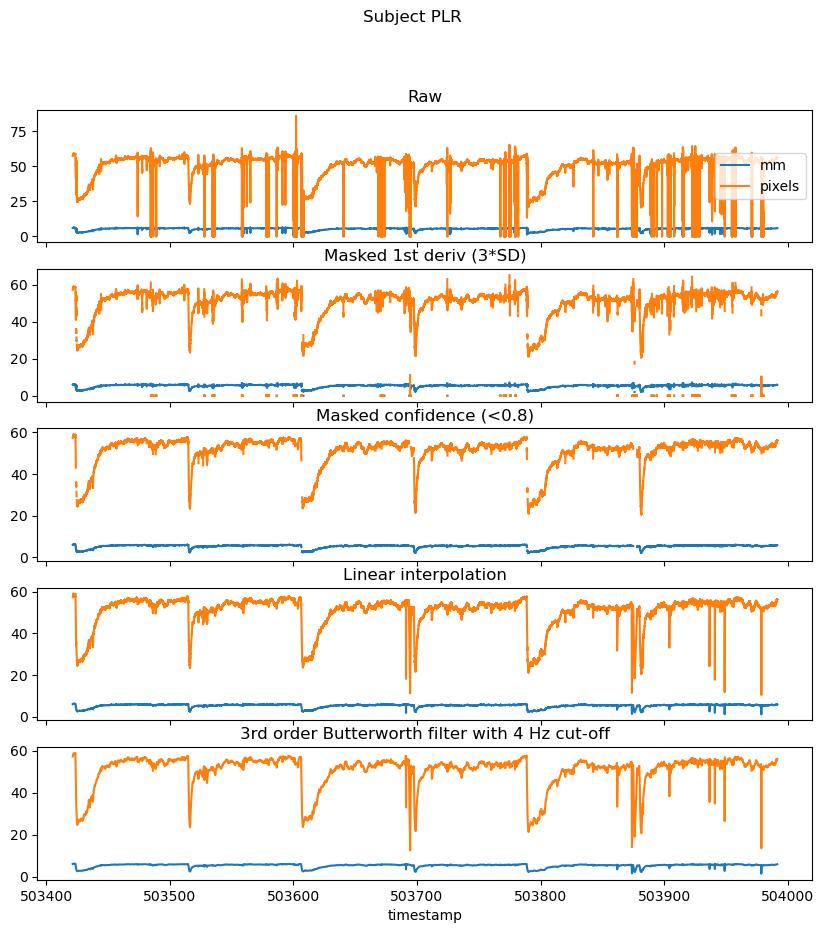

In [14]:
from pyplr import graphing
from pyplr import preproc

# Sampling frequency
SAMPLE_RATE = 120

# Pupil columns to analyse
pupil_cols = ['diameter_3d', 'diameter']

# Make figure for processing
#f, axs = graphing.pupil_preprocessing(nrows=4, subject='Example')
fig, axs = plt.subplots(5, sharex=True, figsize=(10,10))
fig.suptitle('Subject PLR')

# Plot the raw data
samples_eye0[pupil_cols].plot(title='Raw', ax=axs[0], legend=True)
axs[0].legend(loc='center right', labels=['mm', 'pixels'])

# Mask first derivative
samples_eye0 = preproc.mask_pupil_first_derivative(
    samples_eye0, threshold=3.0, mask_cols=pupil_cols)
samples_eye0[pupil_cols].plot(
    title='Masked 1st deriv (3*SD)', ax=axs[1], legend=False)

# Mask confidence
samples_eye0 = preproc.mask_pupil_confidence(
    samples_eye0, threshold=0.8, mask_cols=pupil_cols)
samples_eye0[pupil_cols].plot(
    title='Masked confidence (<0.8)', ax=axs[2], legend=False)

# Interpolate
samples_eye0 = preproc.interpolate_pupil(
    samples_eye0, interp_cols=pupil_cols)
samples_eye0[pupil_cols].plot(
    title='Linear interpolation', ax=axs[3], legend=False)

# Smooth
samples_eye0 = preproc.butterworth_series(
    samples_eye0, fields=pupil_cols, filt_order=3,
    cutoff_freq=4/(SAMPLE_RATE/2))
samples_eye0[pupil_cols].plot(
    title='3rd order Butterworth filter with 4 Hz cut-off',
    ax=axs[4], legend=False);

In [15]:
# export butterworth processed sample data for eye 0
samples_eye0.to_csv(path_base + subj_base + '-butterworth-eye0.csv') # raw data

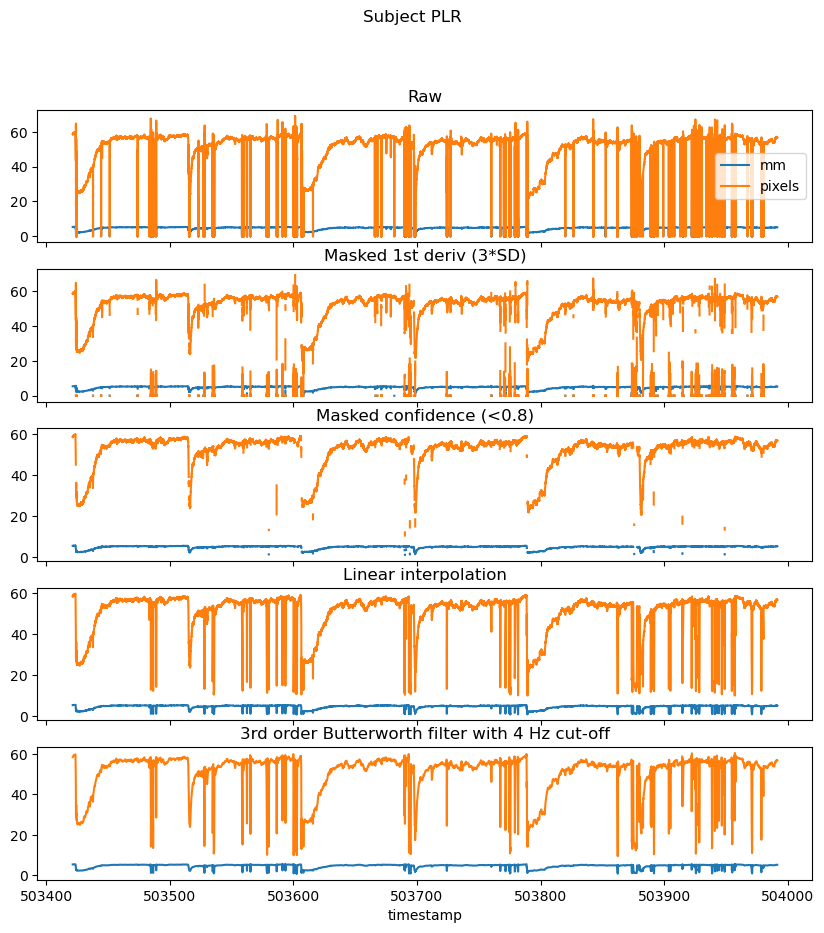

In [16]:
# Sampling frequency
SAMPLE_RATE = 120

# Pupil columns to analyse
pupil_cols = ['diameter_3d', 'diameter']

# Make figure for processing
#f, axs = graphing.pupil_preprocessing(nrows=4, subject='Example')
fig, axs = plt.subplots(5, sharex=True, figsize=(10,10))
fig.suptitle('Subject PLR')

# Plot the raw data
samples_eye1[pupil_cols].plot(title='Raw', ax=axs[0], legend=True)
axs[0].legend(loc='center right', labels=['mm', 'pixels'])

# Mask first derivative
samples_eye1 = preproc.mask_pupil_first_derivative(
    samples_eye1, threshold=3.0, mask_cols=pupil_cols)
samples_eye1[pupil_cols].plot(
    title='Masked 1st deriv (3*SD)', ax=axs[1], legend=False)

# Mask confidence
samples_eye1 = preproc.mask_pupil_confidence(
    samples_eye1, threshold=0.8, mask_cols=pupil_cols)
samples_eye1[pupil_cols].plot(
    title='Masked confidence (<0.8)', ax=axs[2], legend=False)

# Interpolate
samples_eye1 = preproc.interpolate_pupil(
    samples_eye1, interp_cols=pupil_cols)
samples_eye1[pupil_cols].plot(
    title='Linear interpolation', ax=axs[3], legend=False)

# Smooth
samples_eye1 = preproc.butterworth_series(
    samples_eye1, fields=pupil_cols, filt_order=3,
    cutoff_freq=4/(SAMPLE_RATE/2))
samples_eye1[pupil_cols].plot(
    title='3rd order Butterworth filter with 4 Hz cut-off',
    ax=axs[4], legend=False);

In [17]:
# export butterworth processed sample data for eye 1
samples_eye1.to_csv(path_base + subj_base + '-butterworth-eye1.csv') # raw data
# can stop here if necessary

**CAN STOP HERE AND DO ANALYSIS LATER**

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [4]:
# df_pipr = pd.read_csv("C:/Users/kebl6975/Documents/GitHub/cvd_pupillometry/subjectdata/sub-999_ses-02_dat-20230419.csv")
df_pipr_eye0 = pd.read_csv(path_base + subj_base + '-butterworth-eye0.csv')
df_pipr_eye1 = pd.read_csv(path_base + subj_base + '-butterworth-eye1.csv')

# Print header names
# print(df_pipr.columns)

# Extract the column with header "timestamp"
timestamps_eye0 = df_pipr_eye0["timestamp"]
timestamps_eye1 = df_pipr_eye1["timestamp"]
# Extract the column with header "diameter_3d"
diam_3d_eye0 = df_pipr_eye0["diameter_3d"]
diam_3d_eye1 = df_pipr_eye1["diameter_3d"]

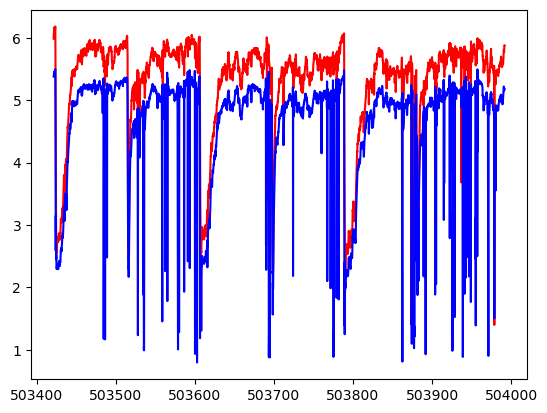

In [5]:
fig = plt.figure()
# plot eye0 in red, eye1 in blue
plt.plot(timestamps_eye0, diam_3d_eye0, 'r') # this should be the smoothed out data - if not, check
plt.plot(timestamps_eye1, diam_3d_eye1, 'b') # this should be the smoothed out data - if not, check

This is copied from the output of cell 11
> Light stamped on frame.world at 503423.47637499997
> Waiting for a light to stamp...
> Light stamped on frame.world at 503514.72842299996
> Waiting for a light to stamp...
> Light stamped on frame.world at 503606.008593
> Waiting for a light to stamp...
> Light stamped on frame.world at 503697.224664
> Waiting for a light to stamp...
> Light stamped on frame.world at 503788.508263
> Waiting for a light to stamp...
> Light stamped on frame.world at 503879.805674

**Edit Cell Below with Timestamps**

In [6]:
# NEED TO EDIT THIS WITH NEW TIMESTAMPS
# finds indices of each timestamp (or closest one before, if exact match cannot be found).
# finds list of timestamps where condition is true, extracts array of just this, then takes last value (closest stamp)
stamp1 = np.where(timestamps_eye0 <= 503423.47637499997)[0][-1]
stamp2 = np.where(timestamps_eye0 <= 503514.72842299996)[0][-1]
stamp3 = np.where(timestamps_eye0 <= 503606.008593)[0][-1]
stamp4 = np.where(timestamps_eye0 <= 503697.224664)[0][-1]
stamp5 = np.where(timestamps_eye0 <= 503788.508263)[0][-1]
stamp6 = np.where(timestamps_eye0 <= 503879.805674)[0][-1]
stamps_eye0 = [stamp1, stamp2, stamp3, stamp4, stamp5, stamp6]
stamps_eye0

[249, 11498, 22621, 33880, 45157, 56364]

In [7]:
# NEED TO EDIT THIS WITH NEW TIMESTAMPS
# finds indices of each timestamp (or closest one before, if exact match cannot be found).
# finds list of timestamps where condition is true, extracts array of just this, then takes last value (closest stamp)
stamp1 = np.where(timestamps_eye1 <= 503423.47637499997)[0][-1]
stamp2 = np.where(timestamps_eye1 <= 503514.72842299996)[0][-1]
stamp3 = np.where(timestamps_eye1 <= 503606.008593)[0][-1]
stamp4 = np.where(timestamps_eye1 <= 503697.224664)[0][-1]
stamp5 = np.where(timestamps_eye1 <= 503788.508263)[0][-1]
stamp6 = np.where(timestamps_eye1 <= 503879.805674)[0][-1]
stamps_eye1 = [stamp1, stamp2, stamp3, stamp4, stamp5, stamp6]
stamps_eye1

[249, 11537, 22690, 33970, 45253, 56491]

In [8]:
from pyplr import utils
from copy import deepcopy

In [9]:
df_data_eye0 = df_pipr_eye0[['timestamp', 'confidence','id','diameter','diameter_3d']]
df_data_eye1 = df_pipr_eye1[['timestamp', 'confidence','id','diameter','diameter_3d']]
df_data_eye1

,timestamp,confidence,id,diameter,diameter_3d
0,503421.455470,1.0,1,58.475819,5.379541
1,503421.463382,1.0,1,58.482357,5.380173
2,503421.471646,1.0,1,58.489821,5.380892
3,503421.479531,1.0,1,58.498157,5.381693
4,503421.487407,1.0,1,58.507304,5.382571
...,...,...,...,...,...
70299,503991.423129,1.0,1,56.864840,5.182485
70300,503991.431584,1.0,1,56.867036,5.182565
70301,503991.439246,1.0,1,56.868482,5.182562
70302,503991.447425,1.0,1,56.869225,5.182489


**Extract ranges from samples based on event timing and sample count, eye 0**

Adapted from extract() from utils.py. Set variables - change as necessary. 
Note: even though ISI is 120, we only want 60s of post measurement

In [10]:
samples_eye0 = df_data_eye0
event_starts_eye0 = stamps_eye0
onset_time = 1
duration_time = 60
offset = -60*onset_time # 60 sample rate, start 1s before light to get baseline
duration = 60*duration_time  # 60 sample rate

# find the indexes of the event starts, and offset by sample count
range_idxs_eye0 = (
    np.searchsorted(samples_eye0.index, event_starts_eye0, "left") + offset
)
range_duration = duration

In [11]:
range_idxs_eye0

array([  189, 11438, 22561, 33820, 45097, 56304], dtype=int64)

In [12]:
# make a hierarchical index for eye 0
samples_eye0["orig_idx"] = samples_eye0.index
midx = pd.MultiIndex.from_product(
    [list(range(len(event_starts_eye0))), list(range(range_duration))],
    names=["event", "onset"],
)

# TODO: can add option for time index here

# get the samples
df_eye0 = pd.DataFrame()
idx = 0
for start_idx in range_idxs_eye0:
    # get the start time and add the required number of indices
    end_idx = start_idx + range_duration - 1  # .loc indexing is inclusive
    if end_idx >= len(samples_eye0):
        end_idx = len(samples_eye0) - 1
    new_df_eye0 = deepcopy(
        samples_eye0.loc[samples_eye0.index[start_idx] : samples_eye0.index[end_idx]]
    )
    #for ba in borrow_attributes:
        #new_df[ba] = events.iloc[idx].get(ba, float("nan"))
    df_eye0 = pd.concat([df_eye0, new_df_eye0])
    idx += 1
    
# if there is an error that doesn't allow the new indices to be set (size mismatch), use the if loop below
if (len(df_eye0)!= len(midx)):
    df_test = df_eye0
    temp_df = deepcopy(df_eye0.loc[df_eye0.index[-1] : df_eye0.index[-1]])
    while len(df_eye0) != len(midx):
        df_eye0= pd.concat([df_eye0, temp_df])

df_eye0.index = midx
print("Extracted ranges for {} events".format(len(event_starts_eye0)))

Extracted ranges for 6 events


C:\Users\kebl6975\AppData\Local\Temp\ipykernel_45896\2141019394.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  samples_eye0["orig_idx"] = samples_eye0.index


In [76]:
df_eye0.index

MultiIndex([(0,    0),
            (0,    1),
            (0,    2),
            (0,    3),
            (0,    4),
            (0,    5),
            (0,    6),
            (0,    7),
            (0,    8),
            (0,    9),
            ...
            (5, 3590),
            (5, 3591),
            (5, 3592),
            (5, 3593),
            (5, 3594),
            (5, 3595),
            (5, 3596),
            (5, 3597),
            (5, 3598),
            (5, 3599)],
           names=['event', 'onset'], length=21600)

**Extract ranges from samples based on event timing and sample count, eye 1**

Adapted from extract() from utils.py. Set variables - change as necessary. 
Note: even though ISI is 120, we only want 60s of post measurement

In [13]:
samples_eye1 = df_data_eye1
event_starts_eye1 = stamps_eye1 
onset_time = 1
duration_time = 60
offset = -60*onset_time # 60 sample rate, start 1s before light to get baseline
duration = 60*duration_time  # 60 sample rate

# find the indexes of the event starts, and offset by sample count
range_idxs_eye1 = (
    np.searchsorted(samples_eye1.index, event_starts_eye1, "left") + offset
)
range_duration = duration

In [14]:
range_idxs_eye1

array([  189, 11477, 22630, 33910, 45193, 56431], dtype=int64)

In [15]:
# make a hierarchical index for eye 1
samples_eye1["orig_idx"] = samples_eye1.index
midx = pd.MultiIndex.from_product(
    [list(range(len(event_starts_eye1))), list(range(range_duration))],
    names=["event", "onset"],
)

# TODO: can add option for time index here

# get the samples
df_eye1 = pd.DataFrame()
idx = 0
for start_idx in range_idxs_eye1:
    # get the start time and add the required number of indices
    end_idx = start_idx + range_duration - 1  # .loc indexing is inclusive
    if end_idx >= len(samples_eye1):
        end_idx = len(samples_eye1) - 1
    new_df_eye1 = deepcopy(
        samples_eye1.loc[samples_eye1.index[start_idx] : samples_eye1.index[end_idx]]
    )
    #for ba in borrow_attributes:
        #new_df[ba] = events.iloc[idx].get(ba, float("nan"))
    df_eye1 = pd.concat([df_eye1, new_df_eye1])
    idx += 1
# if there is an error that doesn't allow the new indices to be set (size mismatch), use the if loop below
if (len(df_eye1)!= len(midx)):
    df_test = df_eye1
    temp_df = deepcopy(df_eye1.loc[df_eye1.index[-1] : df_eye1.index[-1]])
    while len(df_eye1) != len(midx):
        df_eye1= pd.concat([df_eye1, temp_df])
df_eye1.index = midx
print("Extracted ranges for {} events".format(len(event_starts_eye1)))

Extracted ranges for 6 events


C:\Users\kebl6975\AppData\Local\Temp\ipykernel_45896\3597893296.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  samples_eye1["orig_idx"] = samples_eye1.index


In [16]:
df_eye1.index

MultiIndex([(0,    0),
            (0,    1),
            (0,    2),
            (0,    3),
            (0,    4),
            (0,    5),
            (0,    6),
            (0,    7),
            (0,    8),
            (0,    9),
            ...
            (5, 3590),
            (5, 3591),
            (5, 3592),
            (5, 3593),
            (5, 3594),
            (5, 3595),
            (5, 3596),
            (5, 3597),
            (5, 3598),
            (5, 3599)],
           names=['event', 'onset'], length=21600)

**Re-run the processing on the multi-index data, eye 0**

In [17]:
from pyplr import graphing
from pyplr import preproc
# Calculate baselines
baselines_eye0 = df_eye0.loc[:, range(0, -offset), :].mean(level=0)

# New columns for percent signal change
df_eye0 = preproc.percent_signal_change(
    df_eye0, baselines_eye0, ['diameter_3d', 'diameter'])
df_eye0

C:\Users\kebl6975\AppData\Local\Temp\ipykernel_45896\4183176285.py:4: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  baselines_eye0 = df_eye0.loc[:, range(0, -offset), :].mean(level=0)


timestamp  confidence  id   diameter  diameter_3d  orig_idx  \
event onset                                                                    
0     0      503422.991602         1.0   0  58.357400     6.129667       189   
      1      503422.999347         1.0   0  58.346935     6.128622       190   
      2      503423.008499         1.0   0  58.335729     6.127496       191   
      3      503423.015466         1.0   0  58.323963     6.126306       192   
      4      503423.023431         1.0   0  58.311855     6.125076       193   
...                    ...         ...  ..        ...          ...       ...   
5     3595   503908.803321         1.0   0  55.143818     5.749640     59899   
      3596   503908.812979         1.0   0  55.147335     5.749753     59900   
      3597   503908.819206         1.0   0  55.150279     5.749808     59901   
      3598   503908.827572         1.0   0  55.152375     5.749791     59902   
      3599   503908.835421         1.0   0  55.153310     5.749690     59903   

             diameter_3d_pc  diameter_pc  
event onset                               
0     0           -0.016060    -0.000652  
      1           -0.033104    -0.018583  
      2           -0.051479    -0.037786  
      3           -0.070882    -0.057948  
      4           -0.090942    -0.078696  
...                     ...          ...  
5     3595         7.812052     7.778824  
      3596         7.814172     7.785697  
      3597         7.815193     7.791452  
      3598         7.814884     7.795549  
      3599         7.812983     7.797377  

[21600 rows x 8 columns]

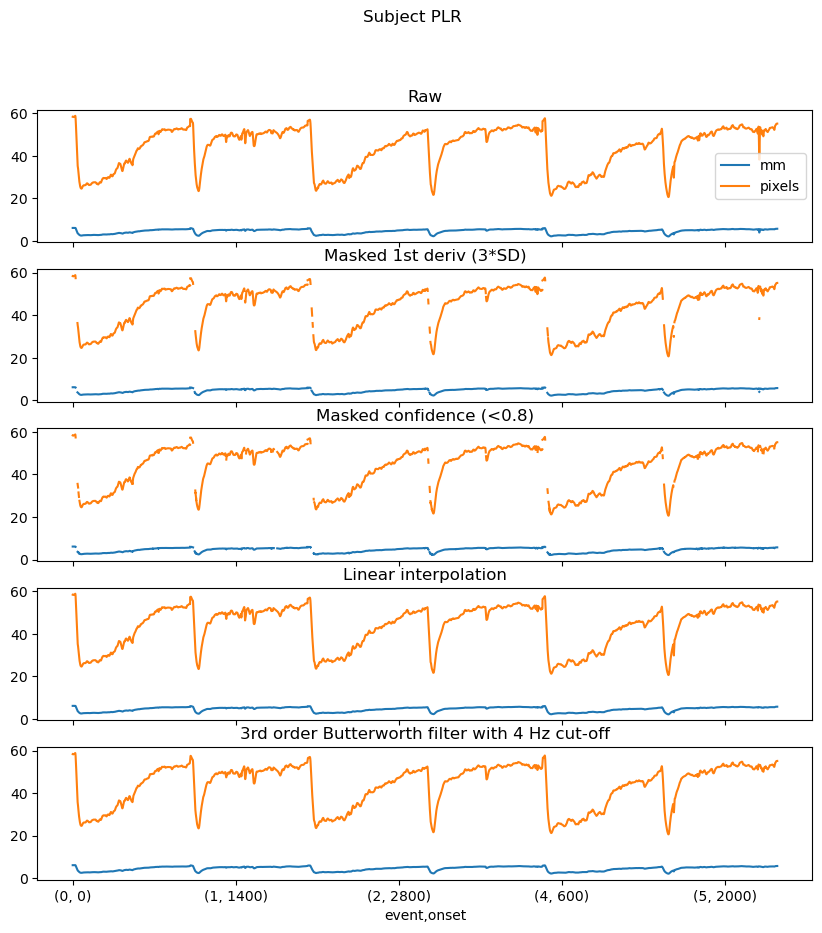

In [18]:
from pyplr import graphing
from pyplr import preproc

# Sampling frequency
SAMPLE_RATE = 120
samples_eye0 = df_eye0

# Pupil columns to analyse
pupil_cols = ['diameter_3d', 'diameter']

# Make figure for processing
#f, axs = graphing.pupil_preprocessing(nrows=4, subject='Example')
fig, axs = plt.subplots(5, sharex=True, figsize=(10,10))
fig.suptitle('Subject PLR')

# Plot the raw data
samples_eye0[pupil_cols].plot(title='Raw', ax=axs[0], legend=True)
axs[0].legend(loc='center right', labels=['mm', 'pixels'])

# Mask first derivative
samples_eye0 = preproc.mask_pupil_first_derivative(
    samples_eye0, threshold=3.0, mask_cols=pupil_cols)
samples_eye0[pupil_cols].plot(
    title='Masked 1st deriv (3*SD)', ax=axs[1], legend=False)

# Mask confidence
samples_eye0 = preproc.mask_pupil_confidence(
    samples_eye0, threshold=0.8, mask_cols=pupil_cols)
samples_eye0[pupil_cols].plot(
    title='Masked confidence (<0.8)', ax=axs[2], legend=False)

# Interpolate
samples_eye0 = preproc.interpolate_pupil(
    samples_eye0, interp_cols=pupil_cols)
samples_eye0[pupil_cols].plot(
    title='Linear interpolation', ax=axs[3], legend=False)

# Smooth
samples_eye0 = preproc.butterworth_series(
    samples_eye0, fields=pupil_cols, filt_order=3,
    cutoff_freq=4/(SAMPLE_RATE/2))
samples_eye0[pupil_cols].plot(
    title='3rd order Butterworth filter with 4 Hz cut-off',
    ax=axs[4], legend=False);

In [86]:
samples_eye0 # this now has the processed data with blinks removed
# where confidence < 0.8, it interpolates the data
# need to run these to improve the outputs
# TODO: double check what df is after this processing

timestamp  confidence  id   diameter  diameter_3d  orig_idx  \
event onset                                                                    
0     0      503422.991602         1.0   0  58.394911     6.134065       189   
      1      503422.999347         1.0   0  58.375998     6.132052       190   
      2      503423.008499         1.0   0  58.357143     6.130046       191   
      3      503423.015466         1.0   0  58.338612     6.128076       192   
      4      503423.023431         1.0   0  58.320668     6.126170       193   
...                    ...         ...  ..        ...          ...       ...   
5     3595   503908.803321         1.0   0  55.124468     5.748486     59899   
      3596   503908.812979         1.0   0  55.124740     5.748494     59900   
      3597   503908.819206         1.0   0  55.124939     5.748490     59901   
      3598   503908.827572         1.0   0  55.125075     5.748477     59902   
      3599   503908.835421         1.0   0  55.125156     5.748458     59903   

             diameter_3d_pc  diameter_pc  interpolated  
event onset                                             
0     0            0.048290     0.057448             0  
      1           -0.142161    -0.122710             0  
      2            0.115421     0.120373             0  
      3           -0.034407    -0.027434             0  
      4           -0.101814    -0.091195             0  
...                     ...          ...           ...  
5     3595         7.739610     7.697045             0  
      3596         7.811774     7.758881             0  
      3597         7.877070     7.823352             0  
      3598         7.788884     7.739047             0  
      3599         7.835734     7.784945             0  

[21600 rows x 9 columns]

ValueError: x and y must have same first dimension, but have shapes (70038,) and (21600, 9)

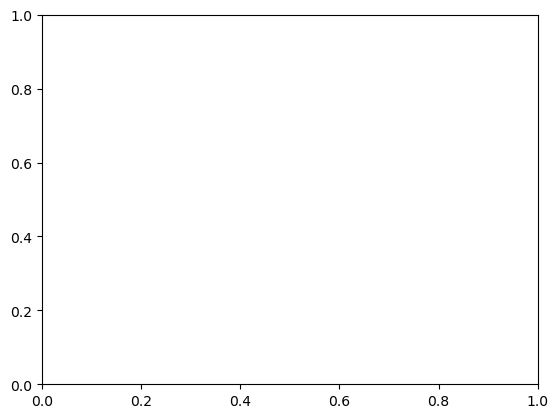

In [65]:
fig = plt.figure()
# plot eye0 in red, eye1 in blue
plt.plot(timestamps_eye0, df_eye0, 'r') # this should be the smoothed out data - if not, check
plt.plot(timestamps_eye1, df_eye1, 'b') # this should be the smoothed out data - if not, check

In [37]:
df_eye0

timestamp  confidence  id   diameter  diameter_3d  orig_idx  \
event onset                                                                    
0     0      503422.991602         1.0   0  58.394665     6.134049       189   
      1      503422.999347         1.0   0  58.289523     6.122372       190   
      2      503423.008499         1.0   0  58.431389     6.138164       191   
      3      503423.015466         1.0   0  58.345127     6.128978       192   
      4      503423.023431         1.0   0  58.307916     6.124846       193   
...                    ...         ...  ..        ...          ...       ...   
5     3595   503908.803321         1.0   0  55.079845     5.743088     59899   
      3596   503908.812979         1.0   0  55.111470     5.746935     59900   
      3597   503908.819206         1.0   0  55.144443     5.750416     59901   
      3598   503908.827572         1.0   0  55.101327     5.745715     59902   
      3599   503908.835421         1.0   0  55.124800     5.748212     59903   

             diameter_3d_pc  diameter_pc  
event onset                               
0     0            0.048290     0.057448  
      1           -0.142161    -0.122710  
      2            0.115421     0.120373  
      3           -0.034407    -0.027434  
      4           -0.101814    -0.091195  
...                     ...          ...  
5     3595         7.739610     7.697045  
      3596         7.811774     7.758881  
      3597         7.877070     7.823352  
      3598         7.788884     7.739047  
      3599         7.835734     7.784945  

[21600 rows x 8 columns]

**Re-run processing on multi-index data, eye 1**

In [38]:
# Calculate baselines
baselines_eye1 = df_eye1.loc[:, range(0, -offset), :].mean(level=0)

# New columns for percent signal change
df_eye1 = preproc.percent_signal_change(
    df_eye1, baselines_eye1, ['diameter_3d', 'diameter'])
df_eye1

C:\Users\kebl6975\AppData\Local\Temp\ipykernel_28716\1788001868.py:2: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  baselines_eye1 = df_eye1.loc[:, range(0, -offset), :].mean(level=0)


timestamp  confidence  id   diameter  diameter_3d  orig_idx  \
event onset                                                                    
0     0      503422.988232         1.0   1  59.350480     5.451786       189   
      1      503422.995369         1.0   1  59.408697     5.457138       190   
      2      503423.007146         1.0   1  59.326817     5.449150       191   
      3      503423.015477         1.0   1  59.372180     5.453177       192   
      4      503423.023948         1.0   1  59.449858     5.460282       193   
...                    ...         ...  ..        ...          ...       ...   
5     3595   503908.391565         1.0   1  56.415931     5.141140     60026   
      3596   503908.399711         1.0   1  56.439265     5.143298     60027   
      3597   503908.408979         1.0   1  56.418341     5.141583     60028   
      3598   503908.416734         1.0   1  56.502220     5.149780     60029   
      3599   503908.423622         1.0   1  56.535846     5.152596     60030   

             diameter_3d_pc  diameter_pc  
event onset                               
0     0           -0.231718    -0.246158  
      1           -0.133772    -0.148309  
      2           -0.279970    -0.285931  
      3           -0.206263    -0.209686  
      4           -0.076238    -0.079128  
...                     ...          ...  
5     3595         7.155394     7.749866  
      3596         7.200371     7.794432  
      3597         7.164624     7.754469  
      3598         7.335465     7.914671  
      3599         7.394167     7.978894  

[21600 rows x 8 columns]

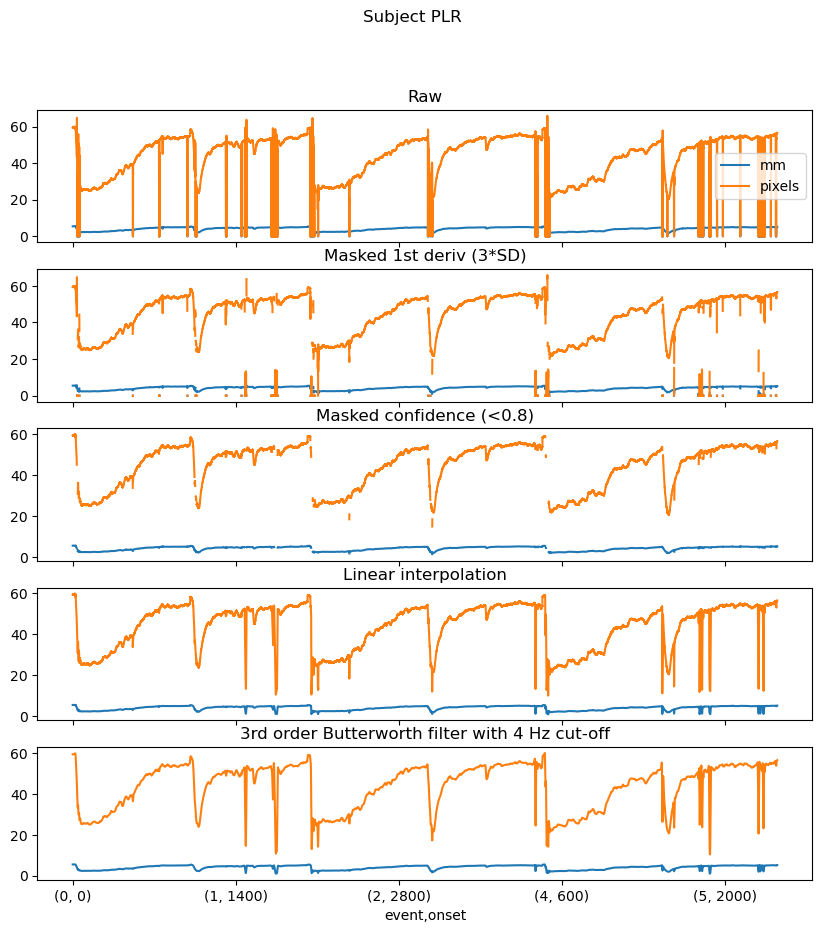

In [39]:
# Sampling frequency
SAMPLE_RATE = 120
samples_eye1 = df_eye1

# Pupil columns to analyse
pupil_cols = ['diameter_3d', 'diameter']

# Make figure for processing
#f, axs = graphing.pupil_preprocessing(nrows=4, subject='Example')
fig, axs = plt.subplots(5, sharex=True, figsize=(10,10))
fig.suptitle('Subject PLR')

# Plot the raw data
samples_eye1[pupil_cols].plot(title='Raw', ax=axs[0], legend=True)
axs[0].legend(loc='center right', labels=['mm', 'pixels'])

# Mask first derivative
samples_eye1 = preproc.mask_pupil_first_derivative(
    samples_eye1, threshold=3.0, mask_cols=pupil_cols)
samples_eye1[pupil_cols].plot(
    title='Masked 1st deriv (3*SD)', ax=axs[1], legend=False)

# Mask confidence
samples_eye1 = preproc.mask_pupil_confidence(
    samples_eye1, threshold=0.8, mask_cols=pupil_cols)
samples_eye1[pupil_cols].plot(
    title='Masked confidence (<0.8)', ax=axs[2], legend=False)

# Interpolate
samples_eye1 = preproc.interpolate_pupil(
    samples_eye1, interp_cols=pupil_cols)
samples_eye1[pupil_cols].plot(
    title='Linear interpolation', ax=axs[3], legend=False)

# Smooth
samples_eye1 = preproc.butterworth_series(
    samples_eye1, fields=pupil_cols, filt_order=3,
    cutoff_freq=4/(SAMPLE_RATE/2))
samples_eye1[pupil_cols].plot(
    title='3rd order Butterworth filter with 4 Hz cut-off',
    ax=axs[4], legend=False);

In [40]:
samples_eye1 # this now has the processed data with blinks removed
# where confidence < 0.8, it interpolates the data
# need to run these to improve the outputs
# TODO: double check what df is after this processing

timestamp  confidence  id   diameter  diameter_3d  orig_idx  \
event onset                                                                    
0     0      503422.988232         1.0   1  59.352268     5.452011       189   
      1      503422.995369         1.0   1  59.361195     5.452716       190   
      2      503423.007146         1.0   1  59.370179     5.453424       191   
      3      503423.015477         1.0   1  59.379257     5.454141       192   
      4      503423.023948         1.0   1  59.388451     5.454870       193   
...                    ...         ...  ..        ...          ...       ...   
5     3595   503908.391565         1.0   1  56.521741     5.151117     60026   
      3596   503908.399711         1.0   1  56.533560     5.152362     60027   
      3597   503908.408979         1.0   1  56.543606     5.153415     60028   
      3598   503908.416734         1.0   1  56.552278     5.154317     60029   
      3599   503908.423622         1.0   1  56.559845     5.155095     60030   

             diameter_3d_pc  diameter_pc  interpolated  
event onset                                             
0     0           -0.231718    -0.246158             0  
      1           -0.133772    -0.148309             0  
      2           -0.279970    -0.285931             0  
      3           -0.206263    -0.209686             0  
      4           -0.076238    -0.079128             0  
...                     ...          ...           ...  
5     3595         7.155394     7.749866             0  
      3596         7.200371     7.794432             0  
      3597         7.164624     7.754469             0  
      3598         7.335465     7.914671             0  
      3599         7.394167     7.978894             0  

[21600 rows x 9 columns]

In [41]:
df_eye1

timestamp  confidence  id   diameter  diameter_3d  orig_idx  \
event onset                                                                    
0     0      503422.988232         1.0   1  59.350480     5.451786       189   
      1      503422.995369         1.0   1  59.408697     5.457138       190   
      2      503423.007146         1.0   1  59.326817     5.449150       191   
      3      503423.015477         1.0   1  59.372180     5.453177       192   
      4      503423.023948         1.0   1  59.449858     5.460282       193   
...                    ...         ...  ..        ...          ...       ...   
5     3595   503908.391565         1.0   1  56.415931     5.141140     60026   
      3596   503908.399711         1.0   1  56.439265     5.143298     60027   
      3597   503908.408979         1.0   1  56.418341     5.141583     60028   
      3598   503908.416734         1.0   1  56.502220     5.149780     60029   
      3599   503908.423622         1.0   1  56.535846     5.152596     60030   

             diameter_3d_pc  diameter_pc  
event onset                               
0     0           -0.231718    -0.246158  
      1           -0.133772    -0.148309  
      2           -0.279970    -0.285931  
      3           -0.206263    -0.209686  
      4           -0.076238    -0.079128  
...                     ...          ...  
5     3595         7.155394     7.749866  
      3596         7.200371     7.794432  
      3597         7.164624     7.754469  
      3598         7.335465     7.914671  
      3599         7.394167     7.978894  

[21600 rows x 8 columns]

**Convert the index-level samples to time (s)**:

In [42]:
ONSET_IDX = 60
SAMPLE_RATE = 60
new_onset = (df_eye0.index.get_level_values('onset')
                    .unique()
            - ONSET_IDX) / SAMPLE_RATE
df_eye0.index = df_eye0.index.set_levels(
    levels=new_onset, level='onset')

In [43]:
df_eye0["colour"] = ""

In [44]:
for (event, onset) in df_eye0.index:
    if event%2==1:
        df_eye0["colour"][event,onset] = "red"
    else:
        df_eye0["colour"][event,onset] = "blue"

C:\Users\kebl6975\AppData\Local\Temp\ipykernel_28716\1670583221.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eye0["colour"][event,onset] = "blue"
C:\Users\kebl6975\AppData\Local\Temp\ipykernel_28716\1670583221.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eye0["colour"][event,onset] = "red"


In [45]:
ONSET_IDX = 60
SAMPLE_RATE = 60
new_onset = (df_eye1.index.get_level_values('onset')
                    .unique()
            - ONSET_IDX) / SAMPLE_RATE
df_eye1.index = df_eye1.index.set_levels(
    levels=new_onset, level='onset')

In [46]:
df_eye1["colour"] = ""

In [47]:
for (event, onset) in df_eye1.index:
    if event%2==1:
        df_eye1["colour"][event,onset] = "red"
    else:
        df_eye1["colour"][event,onset] = "blue"

C:\Users\kebl6975\AppData\Local\Temp\ipykernel_28716\2599913087.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eye1["colour"][event,onset] = "blue"
C:\Users\kebl6975\AppData\Local\Temp\ipykernel_28716\2599913087.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eye1["colour"][event,onset] = "red"


**Plot the PIPR:**

Text(0.5, 1.0, 'Subject = 0')

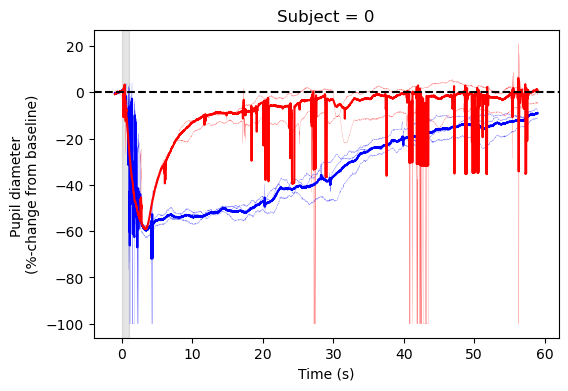

In [48]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(6,4))
for r in range(5):
    if (r==0 or r%2==0):
        c = 'blue'
    else:
        c = 'red'
    df_eye0.loc[r, 'diameter_pc'].plot(
        color=c, lw='.1', ax=ax, legend=False)

# Now show the means
avgs_eye0 = (df_eye0.reset_index()
                .groupby(['colour','onset'], as_index=False)
                .mean())
sns.lineplot(data=avgs_eye0, x='onset', y='diameter_pc', hue='colour',
                palette={'blue':'b','red':'r'}, legend=False)

# Tweak figures
ax.axvspan(0, 1, color='k', alpha=.1)
ax.axhline(0, 0, 1, color='k', ls='--')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Pupil diameter \n(%-change from baseline)')
ax.set_title('Subject = {}'.format(df_eye0['id'][0][0]))

In [49]:
import os
if not os.path.exists(path_base + 'figures'):
    os.makedirs(path_base + 'figures')
# Save the figure in the folder
fig.savefig(path_base + 'figures/' + 'pipr-90s-binoc-sub-008_ses-01_dat-20230925' + '-eye0.png')

In [50]:
df_eye0 # check all is as expected before sending to csv

timestamp  confidence  id   diameter  diameter_3d  \
event onset                                                               
0     -1.000000   503422.991602         1.0   0  58.394665     6.134049   
      -0.983333   503422.999347         1.0   0  58.289523     6.122372   
      -0.966667   503423.008499         1.0   0  58.431389     6.138164   
      -0.950000   503423.015466         1.0   0  58.345127     6.128978   
      -0.933333   503423.023431         1.0   0  58.307916     6.124846   
...                         ...         ...  ..        ...          ...   
5      58.916667  503908.803321         1.0   0  55.079845     5.743088   
       58.933333  503908.812979         1.0   0  55.111470     5.746935   
       58.950000  503908.819206         1.0   0  55.144443     5.750416   
       58.966667  503908.827572         1.0   0  55.101327     5.745715   
       58.983333  503908.835421         1.0   0  55.124800     5.748212   

                  orig_idx  diameter_3d_pc  diameter_pc colour  
event onset                                                     
0     -1.000000        189        0.048290     0.057448   blue  
      -0.983333        190       -0.142161    -0.122710   blue  
      -0.966667        191        0.115421     0.120373   blue  
      -0.950000        192       -0.034407    -0.027434   blue  
      -0.933333        193       -0.101814    -0.091195   blue  
...                    ...             ...          ...    ...  
5      58.916667     59899        7.739610     7.697045    red  
       58.933333     59900        7.811774     7.758881    red  
       58.950000     59901        7.877070     7.823352    red  
       58.966667     59902        7.788884     7.739047    red  
       58.983333     59903        7.835734     7.784945    red  

[21600 rows x 9 columns]

In [51]:
df_eye0.to_csv(path_base + subj_base + '-processed-eye0.csv') # processed data with adjusted onset indices (time in seconds)

<AxesSubplot: xlabel='event,onset'>

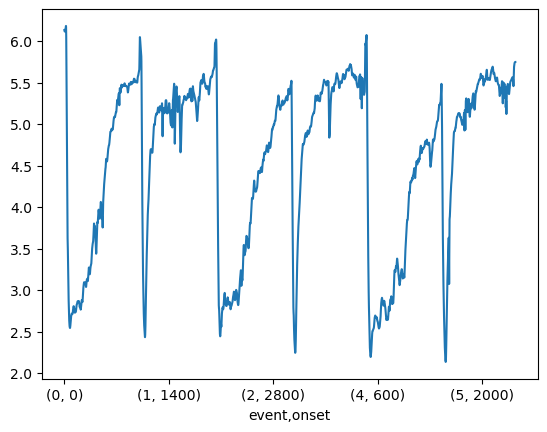

In [52]:
samples_eye0["diameter_3d"].plot()

In [53]:
avgs_eye0.to_csv(path_base + subj_base + '-average-pipr-eye0.csv') # processed data with adjusted onset indices (time in seconds)

In [54]:
df_eye1

timestamp  confidence  id   diameter  diameter_3d  \
event onset                                                               
0     -1.000000   503422.988232         1.0   1  59.350480     5.451786   
      -0.983333   503422.995369         1.0   1  59.408697     5.457138   
      -0.966667   503423.007146         1.0   1  59.326817     5.449150   
      -0.950000   503423.015477         1.0   1  59.372180     5.453177   
      -0.933333   503423.023948         1.0   1  59.449858     5.460282   
...                         ...         ...  ..        ...          ...   
5      58.916667  503908.391565         1.0   1  56.415931     5.141140   
       58.933333  503908.399711         1.0   1  56.439265     5.143298   
       58.950000  503908.408979         1.0   1  56.418341     5.141583   
       58.966667  503908.416734         1.0   1  56.502220     5.149780   
       58.983333  503908.423622         1.0   1  56.535846     5.152596   

                  orig_idx  diameter_3d_pc  diameter_pc colour  
event onset                                                     
0     -1.000000        189       -0.231718    -0.246158   blue  
      -0.983333        190       -0.133772    -0.148309   blue  
      -0.966667        191       -0.279970    -0.285931   blue  
      -0.950000        192       -0.206263    -0.209686   blue  
      -0.933333        193       -0.076238    -0.079128   blue  
...                    ...             ...          ...    ...  
5      58.916667     60026        7.155394     7.749866    red  
       58.933333     60027        7.200371     7.794432    red  
       58.950000     60028        7.164624     7.754469    red  
       58.966667     60029        7.335465     7.914671    red  
       58.983333     60030        7.394167     7.978894    red  

[21600 rows x 9 columns]

Text(0.5, 1.0, 'Subject = 1')

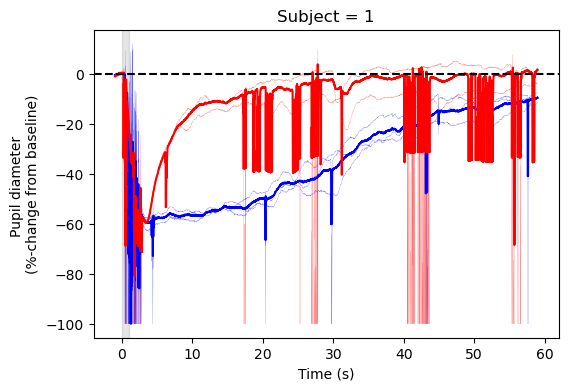

In [55]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(6,4))
for r in range(5):
    if (r==0 or r%2==0):
        c = 'blue'
    else:
        c = 'red'
    df_eye1.loc[r, 'diameter_pc'].plot(
        color=c, lw='.1', ax=ax, legend=False)

# Now show the means
avgs_eye1 = (df_eye1.reset_index()
                .groupby(['colour','onset'], as_index=False)
                .mean())
sns.lineplot(data=avgs_eye1, x='onset', y='diameter_pc', hue='colour',
                palette={'blue':'b','red':'r'}, legend=False)

# Tweak figures
ax.axvspan(0, 1, color='k', alpha=.1)
ax.axhline(0, 0, 1, color='k', ls='--')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Pupil diameter \n(%-change from baseline)')
ax.set_title('Subject = {}'.format(df_eye1['id'][0][0]))

In [56]:
if not os.path.exists(path_base + 'figures'):
    os.makedirs(path_base + 'figures')
# Save the figure in the folder
fig.savefig(path_base + 'figures/' + 'pipr-90s-binoc-sub-008_ses-01_dat-20230925' + '-eye1.png')

In [57]:
df_eye1 # check all is as expected before sending to csv

timestamp  confidence  id   diameter  diameter_3d  \
event onset                                                               
0     -1.000000   503422.988232         1.0   1  59.350480     5.451786   
      -0.983333   503422.995369         1.0   1  59.408697     5.457138   
      -0.966667   503423.007146         1.0   1  59.326817     5.449150   
      -0.950000   503423.015477         1.0   1  59.372180     5.453177   
      -0.933333   503423.023948         1.0   1  59.449858     5.460282   
...                         ...         ...  ..        ...          ...   
5      58.916667  503908.391565         1.0   1  56.415931     5.141140   
       58.933333  503908.399711         1.0   1  56.439265     5.143298   
       58.950000  503908.408979         1.0   1  56.418341     5.141583   
       58.966667  503908.416734         1.0   1  56.502220     5.149780   
       58.983333  503908.423622         1.0   1  56.535846     5.152596   

                  orig_idx  diameter_3d_pc  diameter_pc colour  
event onset                                                     
0     -1.000000        189       -0.231718    -0.246158   blue  
      -0.983333        190       -0.133772    -0.148309   blue  
      -0.966667        191       -0.279970    -0.285931   blue  
      -0.950000        192       -0.206263    -0.209686   blue  
      -0.933333        193       -0.076238    -0.079128   blue  
...                    ...             ...          ...    ...  
5      58.916667     60026        7.155394     7.749866    red  
       58.933333     60027        7.200371     7.794432    red  
       58.950000     60028        7.164624     7.754469    red  
       58.966667     60029        7.335465     7.914671    red  
       58.983333     60030        7.394167     7.978894    red  

[21600 rows x 9 columns]

In [58]:
df_eye1.to_csv(path_base + subj_base + '-processed-eye1.csv') # processed data with adjusted onset indices (time in seconds)

<AxesSubplot: xlabel='event,onset'>

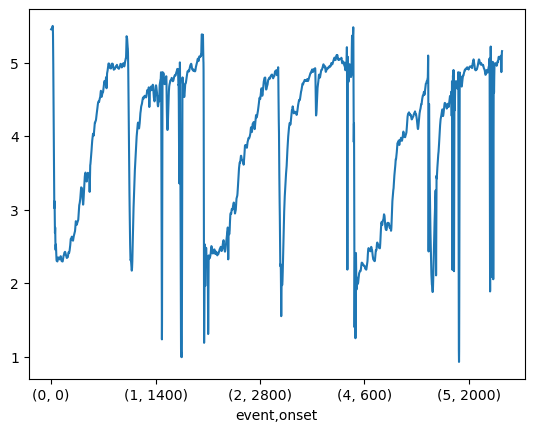

In [59]:
samples_eye1["diameter_3d"].plot()

In [60]:
avgs_eye1.to_csv(path_base + subj_base + '-average-pipr-eye1.csv') # processed data with adjusted onset indices (time in seconds)

**Compute the pupillary light response (optional, skip for now):**

In [ ]:
# adapt this to separate red and blue
from pyplr.plr import PLR

average_plr = df.mean(level=1)['diameter_3d'].to_numpy()
plr = PLR(average_plr,
          sample_rate=60,
          onset_idx=-offset,
          stim_duration=1)

In [ ]:
fig = plr.plot(vel=True, acc=True, print_params=True)

In [ ]:
params = plr.parameters()
params

**Compute the PIPR:**

In [61]:
# code to calculate PIPR at given time
pipr_time = 7 # measure PIPR at t=7s (6s after stimulus turned off)
print(avgs_eye0.loc[avgs_eye0["onset"] == pipr_time])
print(avgs_eye1.loc[avgs_eye1["onset"] == pipr_time])

     colour  onset  event      timestamp  confidence   id  diameter  \
480    blue    7.0    2.0  503609.428946         1.0  0.0  27.06926   
4080    red    7.0    3.0  503700.670478         1.0  0.0  40.20324   

      diameter_3d      orig_idx  diameter_3d_pc  diameter_pc  
480      2.814916  23095.666667      -53.277842   -52.704330  
4080     4.180814  34334.000000      -25.161137   -24.687112  
     colour  onset  event      timestamp  confidence   id   diameter  \
480    blue    7.0    2.0  503609.382070         1.0  1.0  25.984982   
4080    red    7.0    3.0  503700.641569         1.0  1.0  40.275887   

      diameter_3d      orig_idx  diameter_3d_pc  diameter_pc  
480      2.366801  23150.666667      -56.136163   -55.977122  
4080     3.663920  34419.333333      -26.596989   -26.182464  


In [62]:
# eye 0
blue_d_pipr_eye0 = avgs_eye0["diameter_3d"][480]
red_d_pipr_eye0 = avgs_eye0["diameter_3d"][4080]
blue_d_pipr_pc_eye0 = avgs_eye0["diameter_3d_pc"][480]
red_d_pipr_pc_eye0 = avgs_eye0["diameter_3d_pc"][4080]
pipr_diff_eye0 = red_d_pipr_eye0 - blue_d_pipr_eye0
pipr_pc_diff_eye0 = red_d_pipr_pc_eye0 - blue_d_pipr_pc_eye0
print("PIPR (Absolute Difference), Eye 0: ", pipr_diff_eye0)
print("PIPR (Percent Change), Eye 0: ", pipr_pc_diff_eye0)

PIPR (Absolute Difference), Eye 0:  1.3658981785405406
PIPR (Percent Change), Eye 0:  28.116705522406317


In [63]:
# eye 1
blue_d_pipr_eye1 = avgs_eye1["diameter_3d"][480]
red_d_pipr_eye1 = avgs_eye1["diameter_3d"][4080]
blue_d_pipr_pc_eye1 = avgs_eye1["diameter_3d_pc"][480]
red_d_pipr_pc_eye1 = avgs_eye1["diameter_3d_pc"][4080]
pipr_diff_eye1 = red_d_pipr_eye1 - blue_d_pipr_eye1
pipr_pc_diff_eye1 = red_d_pipr_pc_eye1 - blue_d_pipr_pc_eye1
print("PIPR (Absolute Difference), Eye 1: ", pipr_diff_eye1)
print("PIPR (Percent Change), Eye 1: ", pipr_pc_diff_eye1)

PIPR (Absolute Difference), Eye 1:  1.2971185770741611
PIPR (Percent Change), Eye 1:  29.539173470031084
